## Database Fetching


Library import

In [ ]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from scipy import stats
! pip install webrtcvad
import webrtcvad
import collections

SNR

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

Audio File Reading

In [ ]:
def read_audiofile(path):
  sample_rate, signal = scipy.io.wavfile.read(path)
  return sample_rate,signal
# plt.plot(signal)

Pre-Emphasis

In [ ]:
def signal_emphasis(signal):
  pre_emphasis = 0.97
  return  np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
# signaltonoise(emphasized_signal,axis=0,ddof=0)
# emphasized_signal=signal

In [ ]:
class Frame(object):
  def __init__(self,bytes,timestamp,duration):
    self.bytes=bytes
    self.timestamp=timestamp
    self.duration=duration


In [ ]:
def frame_generator(emphasized_signal,frame_size ,frame_stride,sample_rate):
  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = np.zeros((pad_signal_length - signal_length))
  pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(np.int32, copy=False)]
  return frames,indices


In [ ]:
def non_speech_removal(sample_rate, vad, frames,indices):
    # voiced_frames = []

    # for frame in frames:
    #     if vad.is_speech(frame,sample_rate):
    #         voiced_frames.append(frame)

    # return voiced_frames,indices
    padding_duration_ms = 1000
    frame_duration_ms = 20
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False

    voiced_frames = []
    f = []
    for frame in frames:
        is_speech = vad.is_speech(frame, sample_rate)

        # sys.stdout.write('1' if is_speech else '0')
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                # sys.stdout.write('+(%s)' % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                # sys.stdout.write('-(%s)' % (frame.timestamp + frame.duration))
                triggered = False
                yield b''.join([f for f in voiced_frames])
                print('blah1')
                ring_buffer.clear()
                voiced_frames = []
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b''.join([f for f in voiced_frames])
        print('blah2')
    print("blah3")
    return f

Segmentation

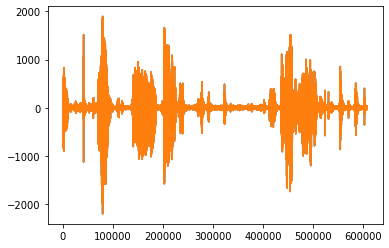

In [ ]:
sample_rate,signal = read_audiofile('/content/Record.wav')
plt.plot(signal)

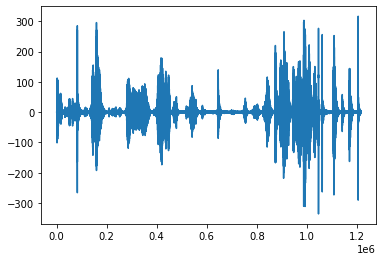

In [ ]:
signal = signal_emphasis(signal)
plt.plot(signal)

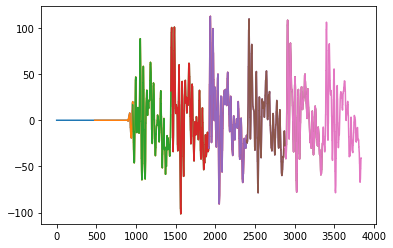

In [ ]:
frames,indices = frame_generator(signal,0.02,0.01,sample_rate)
plt.plot(indices[0],frames[0])
plt.plot(indices[1],frames[1])
plt.plot(indices[2],frames[2])
plt.plot(indices[3],frames[3])
plt.plot(indices[4],frames[4])
plt.plot(indices[5],frames[5])
plt.plot(indices[6],frames[6])

In [ ]:
vad = webrtcvad.Vad()
print(len(frames))
frame2 = non_speech_removal(sample_rate,vad,frames,indices)
# print(len(frame2))

2531


In [ ]:
for i,some in enumerate(frame2):
    print(i)

# SAD

In [ ]:
# !pip install webrtcvad
# import webrtcvad
# vad = webrtcvad.Vad()
# vad.set_mode(3)
# not_voice = 0
# voice = 0
# for frame  in frames:
#     fr = np.int16(frame).tobytes()
#     # print(vad.is_speech(fr, sample_rate))
#     if vad.is_speech(fr, sample_rate):
#         plt.plot(fr)
#         not_voice +=1
#     else:
#         voice+=1
# print("non-voice ",end=" ")
# print(not_voice)
# print("voice ",end=" ")
# print(voice)

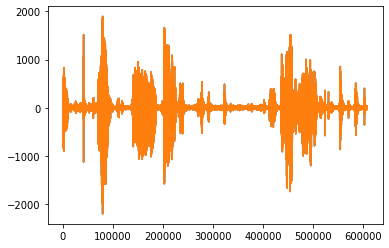

In [ ]:
plt.plot(signal)

Hamming Window

In [ ]:
frames *= np.hamming(frame_length)

Power Spectrum

In [ ]:
NFFT = 512
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

Filter Banks

In [ ]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
# plt.plot(fbank[:5])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability

filter_banks = 20 * np.log10(filter_banks)


MFCC

In [ ]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
# plt.specgram(mfcc[0],Fs=sample_rate)
# plt.imshow(mfcc,extent=[0,4.2,0,48000], cmap='jet',
#            vmin=0, vmax=12, origin='lowest', aspect='auto')
# plt.colorbar()
# plt.show()

In [ ]:
! pip install git+https://github.com/amsehili/auditok
import auditok

  Cloning https://github.com/amsehili/auditok to /tmp/pip-req-build-e5kpbf7g
  Running command git clone -q https://github.com/amsehili/auditok /tmp/pip-req-build-e5kpbf7g
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for auditok: filename=auditok-0.2.0-py3-none-any.whl size=1491680 sha256=842a2aaf7b17196318496944177127059399ab0582e2910a33db01e52325e732
  Stored in directory: /tmp/pip-ephem-wheel-cache-pmxzepxd/wheels/b9/59/0f/835224f55438618ce18ecdd3ef885cd88dbb44c9d57daf9071
Successfully built auditok


In [ ]:

audio_regions = auditok.split(
    "Record.wav",
    min_dur=0.02,     # minimum duration of a valid audio event in seconds
    max_dur=0.1,       # maximum duration of an event
    max_silence=0.05, # maximum duration of tolerated continuous silence within an event
    energy_threshold=44 # threshold of detection
)
# audio_regions.splitp()
# print(audio_regions)
l = []
for i, r in enumerate(audio_regions):

    # Regions returned by `split` have 'start' and 'end' metadata fields
    # print("Region {i}: {r.meta.start:.3f}s -- {r.meta.end:.3f}s".format(i=i, r=r))
    l.append([int(r.meta.start*sample_rate),int(r.meta.end*sample_rate)])

    # play detection
    # r.play(progress_bar=True)

    # region's metadata can also be used with the `save` method
    # (no need to explicitly specify region's object and `format` arguments)
    # filename = r.save("region_{meta.start:.3f}-{meta.end:.3f}.wav")
    # print("region saved as: {}".format(filename))

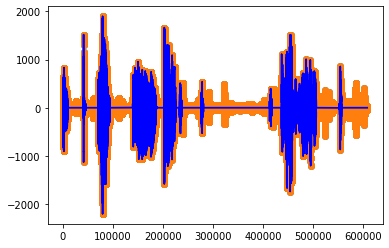

In [ ]:
vocal_signal = [[0,0]]*len(signal)
for v in l:
    vocal_signal[v[0]:v[1]] = signal[v[0]:v[1]]

plt.plot(signal,'o')
plt.plot(vocal_signal,'b')

     |████████████████████████████████| 66 kB 2.6 MB/s 
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp37-cp37m-linux_x86_64.whl size=72290 sha256=b63fb6ecc3f6f444224c627968400ac6d88bd775739c9a63b3f2bbb7c6d662a5
  Stored in directory: /root/.cache/pip/wheels/11/f9/67/a3158d131f57e1c0a7d8d966a707d4a2fb27567a4fe47723ad
Successfully built webrtcvad


In [ ]:
# audio, sample_rate = scipy.io.wavfile.read('/content/Record.wav')
# vad = webrtcvad.Vad(mode=1)
# frames = frame_generator(30, audio, sample_rate)
# frames = list(frames)
# segments = vad_collector(sample_rate, 30, 300, vad, frames)
# for i, segment in enumerate(segments):
#     # path = 'chunk-%002d.wav' % (i,)
#     print(' Writing %s' % (path,))
#     # write_wave(path, segment, sample_rate)

NameError: ignored